<span style="color: blue; font-size: 30px;">Contents:</span>

<hr> <!-- Horizontal Rule using HTML -->

<ol>
  <li><strong>Install & Import Dependencies</strong></li>
  <li><strong>Functions</strong></li>
  <li><strong>Architectures</strong></li>
  <li>
    <strong>Generating Datasets</strong>
    <ol>
      <li>General Data Processing</li>
      <li>RE</li>
      <li>SE</li>
    </ol>
  </li>
  <li>
    <strong>Training & Evaluation</strong>
    <ol>
      <li>RE</li>
      <li>SE</li>
    </ol>
  </li>
</ol>

# Install & Import dependencies

In [53]:
%reload_ext autoreload
%autoreload 2

In [54]:
!pip uninstall -y -q nilmtk nilm_metadata
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilmtk@master
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilm_metadata@master
!pip install tqdm

#!mamba install tensorflow-gpu==2.11.0 -y -q
!pip install tensorflow[and-cuda]

  Cloning https://github.com/nilmtk/nilmtk (to revision master) to /tmp/pip-req-build-9275vbuz
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilmtk /tmp/pip-req-build-9275vbuz
  Resolved https://github.com/nilmtk/nilmtk to commit 2ab4427e7c44732d547affc7790acb3da98ea4c6
  Preparing metadata (setup.py) ... done
  Created wheel for nilmtk: filename=nilmtk-0.4.0.dev1+git.2ab4427-py3-none-any.whl size=279179 sha256=5a6987a29488e21ecb58594760c899b94e35c07fd4b04df97c01eddc4ef5e067
  Stored in directory: /tmp/pip-ephem-wheel-cache-1_h5bqfd/wheels/05/a4/8e/b767c3d1714f61fd30ec991c25780be8cc04c474da8205aeee
Successfully built nilmtk
  Cloning https://github.com/nilmtk/nilm_metadata (to revision master) to /tmp/pip-req-build-pk5o0oqe
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilm_metadata /tmp/pip-req-build-pk5o0oqe
  Resolved https://github.com/nilmtk/nilm_metadata to commit 7ed4bab9062d04cb35c6b6000b451715dc5ab4af
  Prep

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from nilmtk import DataSet
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from joblib import Memory
import pickle
from pprint import pprint

import multiprocessing as mp

from typing import Dict

!pip install -q scikit-learn-intelex
from sklearn import pipeline, metrics, linear_model, model_selection, multioutput, tree, ensemble, neural_network

!pip install xgboost
import xgboost as xgb

import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix

from matplotlib import pyplot as plt 

# GPU boost
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

memory = Memory(location='./cache')

import numpy as np
import warnings
import math

from keras.models import Model
from keras.layers import Flatten, Dense, Input, GRU, BatchNormalization, LSTM, Bidirectional, AveragePooling1D
from keras.layers import Conv1D, Conv1DTranspose, LocallyConnected1D, SeparableConv1D, ConvLSTM1D
from keras.layers import MaxPooling1D, Dropout
from keras.layers import GlobalMaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.preprocessing import image
#from keras.utils import layer_utils
#from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)


2024-02-22 11:34:01.950497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 11:34:01.950546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 11:34:01.951742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 11:34:01.957544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 11:34:02.579584: W tensorflow/compiler/tf2

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100 80GB PCIe MIG 3g.40gb, compute capability 8.0


# Functions

<p> To load raw datasets we used the following functions. They expect datasets in .hdf5 format. </p>


In [4]:
@memory.cache

def load_refit_dataset():
    try:
        dataset = DataSet('./refit.hdf5')

        samples = []
        for building_idx, building in dataset.buildings.items():
            for meter in building.elec.all_meters():

                data = list(meter.load())
                assert len(data) == 1

                assert len(meter.appliances) < 2

                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                samples.append(sample)
                
        return samples

    except Exception as e:
        dataset.store.close()
        raise e
        
def load_ukdale_dataset():
    try:
        dataset = DataSet('./ukdale.hdf5')

        samples = []
        for building_idx, building in dataset.buildings.items():
            for meter in building.elec.all_meters():

                data = list(meter.load())
                assert len(data) == 1

                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                samples.append(sample)
                
        return samples

    except Exception as e:
        dataset.store.close()
        raise e

<p> The 2 cells below contain function that will be used to process data into x_train, x_test, y_train, y_test, labels format in Section 4 of this notebook. </p>

In [5]:
def data_preparation(dataset):
    X = defaultdict(lambda: [])

    for (idx, appliances, data, good_sections) in dataset:
        if not appliances:
            continue
            
        appliance = appliances[0]
        data = data[0]
    
        samples = [data[good.start:good.end] for good in good_sections]
        X[appliance].extend(samples)
        
    for appliance, samples in X.items():
        print(appliance, len(samples))
        
    return X


def test_appliance_augmentator(augmentator, *args, **kwargs):
    X, y, labels = next(augmentator(processed_data, *args, **kwargs))

    f, ax = plt.subplots()
    ax.set_title('Augmented time-series')
    ax.plot(X)
    f.show()
    
    
    
    n_appliances = kwargs.get('n_appliances_per_sample', None)
    f, ax = plt.subplots()

    
    print('Number of positive datapoints per appliance')
    for mask, label in zip(y, labels):
        if np.sum(mask) == 0:
            continue
        
        print(f'{label}:\t {np.sum(mask)}')
        

        tmp = X.copy()
        tmp[~mask] = 0
        ax.plot(tmp, linestyle=None, marker='.', label=label, alpha=0.5)
        #ax.plot(np.ma.masked_where(mask, np.full_like(X, idx)), marker='.', label=label)
    

    f.legend(title='markers based on mask')
    f.show()
    
from typing import Iterator, List, Tuple

def appliance_augmentator(dataset:Dict[str,list], sample_length:int, n_appliances_per_sample:int, random_state:int=None) -> Iterator[Tuple[np.ndarray, np.ndarray, List[str]]]:
    
    # Initialize seeded random number generator
    rng = np.random.default_rng(seed=random_state)
    
    # How many appliances are mixed together
    N = n_appliances_per_sample
    
    # Sample length / Window size
    L = sample_length
    
    # Noise floor
    NOISE_FLOOR = 20.0
    
    # Get all available appliances
    appliance_names = tuple(dataset.keys())
    
    # How many appliances are there?
    n_appliances = len(appliance_names)
    print("Number of appliances: ", n_appliances)
    # Start endless generator of samples
    while True:
        # pre-allocate array for time series
        series = np.zeros(L, dtype=np.float64)
        
        # pre-allocate boolean array for masks
        labels = np.zeros((n_appliances, L), dtype=bool)
        
        # Select N random appliances (no replace, because same appliance should not appear twice in the same sample)
        for appliance_idx in rng.choice(n_appliances, size=N, replace=False):
            appliance_name = appliance_names[appliance_idx]

            # Pick random sample of a selected appliance
            n_available_samples = len(dataset[appliance_name])
            sample_idx = rng.choice(n_available_samples)
            
            # retrieve sample as NumPy array with appropriate dimensions
            sample_series = dataset[appliance_name][sample_idx].iloc[:].to_numpy().squeeze(axis=-1)
            
            # If sample is too short (shorter than L), give padding on both sides.
            if len(sample_series) <= L:
                padding = L // 2
                sample_series = np.pad(sample_series, (padding, padding), mode='constant', constant_values=0)
            
            
            # The total length of sample time-series
            sample_len = len(sample_series)
            
            # Sanity check(s)
            assert sample_len >= L, f'Sample length should be equal or larger than L: {sample_len} >= {L}'
            
            sample_offset = rng.choice(sample_len - L)
            
            sample = sample_series[sample_offset:sample_offset+L]
            
            mask = sample > NOISE_FLOOR  # find samples that are above noise floor
            
            series[:] += sample
            labels[appliance_idx, :] |= mask  # logical ORing the mask
            
        # Add random (constant) offset
        #series += rng.random() * (NOISE_FLOOR)
            
        # There has to be two samples present. Even though we combined two subsets, one or both could be empty.
        # Workaround until area of interest is implemented.
        if not (np.sum([(np.any(label) > 0) for label in labels]) == N):
            continue
            
        yield series, labels, appliance_names
        
        
        
import multiprocessing as mp



def process(random_state):
    # Initialize internal seeded random number generator
    rng = np.random.default_rng(seed=random_state)
    
    # Try to generate valid sample
    #while True:
    # pre-allocate array for time series
    series = np.zeros(L, dtype=np.float64)

    # pre-allocate boolean array for masks
    labels = np.zeros((n_appliances, L), dtype=bool)

    # Select N random appliances (no replace, because same appliance should not appear twice in the same sample)
    # h
    for appliance_idx in rng.choice(n_appliances, size=N, replace=False):
        appliance_name = appliance_names[appliance_idx]

        # Pick random sample of a selected appliance
        n_available_samples = len(dataset[appliance_name])
        sample_idx = rng.choice(n_available_samples)

        # retrieve sample as NumPy array with appropriate dimensions
        try:
            sample_series = dataset[appliance_name][sample_idx].iloc[:].to_numpy().squeeze(axis=-1)
        except ValueError:
            continue

        # If sample is too short (shorter than L), give padding on both sides.
        if len(sample_series) <= L:
            padding = L // 2
            sample_series = np.pad(sample_series, (padding, padding), mode='constant', constant_values=0)


        # The total length of sample time-series
        sample_len = len(sample_series)

        # Sanity check(s)
        assert sample_len >= L, f'Sample length should be equal or larger than L: {sample_len} >= {L}'

        while True:
            sample_offset = rng.choice(sample_len - L)
            sample = sample_series[sample_offset:sample_offset+L]
            
            mask = sample > NOISE_FLOOR  # find samples that are above noise floor
            
            if np.any(mask):
                break



        series[:] += sample
        labels[appliance_idx, :] |= mask  # logical ORing the mask

    # There has to be two samples present. Even though we combined two subsets, one or both could be empty.
    # Workaround until area of interest is implemented.
    #if (np.sum([(np.any(label) > 0) for label in labels]) == N):
    #    break

    return series, labels, appliance_names
            


def parallel_appliance_augmentator(_dataset:Dict[str,list], sample_length:int, n_appliances_per_sample:int, n_samples:int, random_state:int=None) -> list:
    import sys
    
    global N, L, NOISE_FLOOR, appliance_names, n_appliances, dataset
    
    dataset = _dataset

    # How many appliances are mixed together
    N = n_appliances_per_sample

    # Sample length / Window size
    L = sample_length

    # Noise floor
    NOISE_FLOOR = 20.0

    # Get all available appliances
    appliance_names = tuple(dataset.keys())

    # How many appliances are there?
    n_appliances = len(appliance_names)
    
    # if random_state is not defined, generate it on the fly
    if random_state == None:
        random_state = np.random.randint(0, sys.maxsize)
            
    with mp.Pool() as pool:
        outputs = pool.map(process, np.arange(n_samples) + random_state)
        
    return tuple(outputs)

In [80]:
import random
import numpy
import math
from sklearn.model_selection import train_test_split


def DevicesDataXY(number_of_datasets: int, 
                  number_of_devices_in_datasets: int, 
                  number_of_all_devices: int):
    """
    Args:
        number_of_dataset (int): a number of datasets used, we use multiple datasets in the Dictlist to evaluate different randomly generated datasets
        number_of_devices_in_datasets (int): a number of devices in total (DiT) that will be present in the dataset
        number_of_all_devices (int): number of all devices that are available for the dataset
        
    Returns:
        devicesX_Y (list)
        dataX_Y (list)
    
    This function uses processed_data and shapes it into two lists 
    one of them contains data from devices (dataX_Y) and one of them names of devices (devicesX_Y).
    Lists contain multiple datasets specified with number_of_datasets, all of which have 
    the same number of devices in them, specified by number_of_devices_in_datasets.
    We choose devices for datasets randomly, thus we have to specify the number of all devices in the REFIT (22) or UKDALE dataset (54).
    """
    
    # we extract the dictionary processed_data into a list AllTable
    AllTable = [[k,v] for k,v in processed_data.items()]
    
    devicesX_Y = []
    dataX_Y = []
    
    # for loop goes over all datasets
    for i in range(0,number_of_datasets):    
        devicesY = []
        dataY = []
        j = 0
        
        # while loop goes over all devices in datasets
        while j < number_of_devices_in_datasets:
            
            # we get a random number with random library
            random_number = random.randrange(number_of_all_devices)
            
            # we use the random number to get a random device and random data that belongs to it from AllTable
            random_device = AllTable[random_number][0]
            random_data = AllTable[random_number][1]
            
            # we append the device and its data if it doesn't already exist 
            # and thus avoid having the same device more then once in the same dataset
            if random_device not in devicesY:
                devicesY.append(random_device)
                dataY.append(random_data)
                j += 1
        
        devicesX_Y.append(devicesY)
        dataX_Y.append(dataY)
    
    return devicesX_Y, dataX_Y


def ListsToDictlist(devices: list, data: list, number_of_devices: int):
    
    """
    This function takes lists from DevicesDataXY or DevicesDataHoly5 and
    turns each of the sublists into a dictionary and then appends those dicitonaries into a list. 
    
    Args:
        devices (list): a list of devices {devicesX_Y}
        data (list): a list of data from devices {dataX_Y}
        number_of_devices (int): 
        
    Returns:
        Dictlist (dict): a dictionary of lists
    
    """
    
    Dictlist=[]
    
    # we make dictionaries out of lists that we input and append them to list of dictionaries (Dictlist)
    for i in range(0,number_of_devices):
        dictionary=dict(zip(devices[i], data[i]))
        Dictlist.append(dictionary)
        
    return Dictlist


def GenerateXXYYL(Dictlist: list, 
              sample_length: int, 
              n_appliances_per_sample: int, 
              dataset_number: int,
              number_of_generated_samples: int
                     ):
    
    """
    Args:
        Dictlist (list): a list of dicitionaries generated by function ListsToDictlist
        sample_length (int): length of samples aka. length of the timewindow, we use 2550 as proposed and explained by Tanoni et al.
        dataset_number (int): number of the dataset, we have multiple datasets in the Dictlist to evaluate different randomly generated datasets
        n_appliances_per_sample (int): number of active devices (AD)
        number_of_generated_samples (int): number of all samples generated, so len(x_train) + len(x_test)

    Returns:
        x_train
        x_test
        y_train
        y_test
        labels
    """ 
    
    X, Y, labels = [], [], None
    
    generator = parallel_appliance_augmentator(Dictlist[dataset_number], 
                                      sample_length=sample_length, 
                                      n_appliances_per_sample=n_appliances_per_sample,
                                      n_samples=number_of_generated_samples,
                                      random_state=0xDEADBEEF)
    
    for idx, (_x, _y, labels) in zip(range(number_of_generated_samples), generator):
        X.append(_x), Y.append(_y)
        
    X, Y = np.asarray(X), np.asarray(Y)
    y = np.any(Y, axis=-1) > 0
    sample_weight = np.sum(Y, axis=-1) / 128
    
    # split into train test sets
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # add the needed dimension
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    
    return x_train, x_test, y_train, y_test, labels



def GenerateRandomXXYYL(Dictlist: list, 
              sample_length: int,  
              dataset_number: int,
              table_of_options: list,
              number_of_generated_samples: int
              ):
    
    """
    Args:
        Dictlist (list): a list of dicitionaries generated by function ListsToDictlist
        sample_length (int): length of samples aka. length of the timewindow, we use 2550 as proposed and explained by Tanoni et al.
        dataset_number (int): number of the dataset, we have multiple datasets in the Dictlist to evaluate different randomly generated datasets
        table_of_options (list): a list of possible active devices (AD)
        number_of_generated_samples (int): a number of samples that we generate, we use 120_000
    
    Returns:
        x_train
        x_test
        y_train
        y_test
        labels
        
        These datasets consist of equal parts of options from table of options.
        EX: If you have table_of_options = [1,2,3,4] the dataset will be 1/4 data with 1 active device, 1/4 data with 2 active devices, ...
        Dataset is mixed so that samples are randomly dispersed throughout the dataset
    """
    
    from tqdm import tqdm
    from multiprocessing import Pool
    
    print('Generating datasets with variable active devices ...')
    
    # First we calculate the number of samples that needs to be generated for each of the datasets that will be mixed into one
    number_of_generated_samples = number_of_generated_samples / len(table_of_options)
    number_of_generated_samples = int(number_of_generated_samples)
    
    # we introduce np.arrays in appropriate shape by making them as the first dataset with table_of_options[0] active devices
    print(f"{table_of_options[0]} AD")
    x_tr, x_te, y_tr, y_te, labels = GenerateXXYYL(Dictlist,
                                                        sample_length,
                                                        table_of_options[0],
                                                        dataset_number,
                                                        number_of_generated_samples)
    
    # we rename them for later use if len(table_of_options) > 1
    x_train = x_tr
    x_test = x_te
    y_train = y_tr
    y_test = y_te

    # we make the rest of the datasets and append them to the first one
    for i in range(1,len(table_of_options)):
        print(f"{i+1} AD")
    #    if table_of_options[i] == 0: continue
        n_appliances_per_sample = table_of_options[i]
        x_tr, x_te, y_tr, y_te, lab = GenerateXXYYL(Dictlist,
                                                        sample_length,
                                                        n_appliances_per_sample,
                                                        dataset_number,
                                                        number_of_generated_samples)
        x_train = np.append(x_train, x_tr, axis=0)
        x_test = np.append(x_test, x_te, axis=0)
        y_train = np.append(y_train, y_tr, axis=0)
        y_test = np.append(y_test, y_te, axis=0)
        
        
    # we print out the final shapes before returning new datasets
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
        
    
    # Now that we have a dataset that consists of len(table_of_options) datasets with different numbers of active devices,
    # we just have to make the final dataset that will be made of exactly the same samples but in a random order.
    
    # To do so first introduce new tables  
    tm_train, tm_test = [], []
    
    # We adjust the number_of_generated_samples back to its original value
    number_of_generated_samples = int(number_of_generated_samples*len(table_of_options))
    
    # we fill tables with integers in order 1,2,3,4,5,6...
    
    #for m in range(1,int(number_of_generated_samples*0.8)):
    for m in range(1,int(math.floor((number_of_generated_samples*0.8)/len(table_of_options))*len(table_of_options)-1)):
        tm_train.append(m)
    
    #for n in range(1,int(number_of_generated_samples*0.2)):
    for n in range(1,int(math.floor((number_of_generated_samples*0.2)/len(table_of_options))*len(table_of_options)-1)):
        tm_test.append(n)
    
    # we shuffle the order of those integers so that it is random
    random.shuffle(tm_train)
    random.shuffle(tm_test)
    
    # we introduce np.arrays in an appropriate shape
    x_train_random = np.empty((0, sample_length, 1))
    y_train_random = np.empty((0, len(Dictlist[dataset_number])), dtype=bool)
    x_test_random = np.empty((0, sample_length, 1))
    y_test_random = np.empty((0, len(Dictlist[dataset_number])), dtype=bool)
    
    # we concatenate to the arrays by using random order of tm_train
    # to make x and y array in the same random order (because we move the same random row in x and y train dataset)
    # we split x : y = 80 : 20 like usual
    
    for g in tqdm(range(0,int(math.floor((number_of_generated_samples*0.8)/len(table_of_options))*len(table_of_options)-3))):
        x_applicable = np.expand_dims(x_train[tm_train[g]], axis=0)
        y_applicable = np.expand_dims(y_train[tm_train[g]], axis=0)
        x_train_random = np.concatenate((x_train_random, x_applicable), axis=0)
        y_train_random = np.concatenate((y_train_random, y_applicable), axis=0)

    for h in tqdm(range(0,int(math.floor((number_of_generated_samples*0.2)/len(table_of_options))*len(table_of_options)-3))):
        x_app = np.expand_dims(x_test[tm_test[h]],axis=0)
        y_app = np.expand_dims(y_test[tm_test[h]],axis=0)
        x_test_random = np.concatenate((x_test_random, x_app), axis=0)
        y_test_random = np.concatenate((y_test_random, y_app), axis=0)

    # we print out the final shapes before returning new datasets
    print(x_train_random.shape, x_test_random.shape, y_train_random.shape, y_test_random.shape)
    
    return x_train_random, x_test_random, y_train_random, y_test_random, labels



def class_weights_tool(y_test):
    
    """
    This function returns class weights for each device in a prticular dataset in a form of a dicitionary.
    It does so by simply counting how many times the device is present througout the dataset.
    
    Args:
        y_test (list): the usual y_test part of the dataset, used in ML
        
    Returns: 
        class_weights_dictionary (dict): a dictionary which contains a number for each device which represents how many times the device appears in the dataset
    """
    
    # inspired by Ronnie Coleman
    light_weight, nums = [], []
    
    # this for loop goes over the collumns of the y_test dataset
    for j in range(0,len(y_test[0])):             
        
        count=0
        
        # gives 0,1,2,3,4,5,6....
        nums.append(j)
        
        # this loop goes over the rows in the y_test dataset
        for i in range(0,len(y_test)):
            
            # we count Trues in the whole column of y_test dataset
            if y_test[i][j] == True: count+=1     
        
        # we append Trues for the column of y_test dataset to the list light_weight
        light_weight.append(count)
        
    # makes the dictionary    
    class_weights_dictionary = dict(zip(nums, light_weight))             
    
    return class_weights_dictionary

In [79]:
y_train_random = np.empty((0, len(Dictlist[0])), dtype=bool)
y_train_random

array([], shape=(0, 15), dtype=bool)

# Architectures

<p>In the next cell there is the code for our proposed architecture CtRNN. If visualized, it would look like this:</p>

<img src="./notebook_pics/architecture.png" alt="Alt Text" width="720"/>

In [7]:
"""
           CtRNN
"""
def CtRNN(classes, window_size):

    # Determine proper input shape
    input_shape = (window_size,1)
    img_input = Input(shape=input_shape)
            
    # Conv. Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block1_pool')(x)

    # Conv. Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block2_pool')(x)

    # Conv. Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block3_pool')(x)

    # Conv. Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block4_pool')(x)
    
    # Trans. conv. 
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv1')(x)
    x = AveragePooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer
    x = GRU(64, activation='tanh', recurrent_activation='sigmoid')(x)                

    x = Flatten(name='flatten')(x)

    # Fully connected layers
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    
    # Output
    x = Dense(classes, activation='sigmoid', name='predictions')(x)

    inputs = img_input

    model = Model(inputs, x, name='CtRNN')
    
    return model

<p> Up next is the architecture VGG11 adapted to time series. Its just a 1D version of the well known architecture: </p>
<img src="./notebook_pics/VGG11.png" alt="Alt Text" width="720"/>

In [8]:
"""
           VGG11 for TS
"""
def VGG11_1D(classes,
             window_size,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = MaxPooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block4_pool')(x)

    # Block 5
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg11_1D')
    return model

# Generating Datasets

## General Data Processing

<p> 
The following cells must be employed, whether your goal is to generate RE or SE dataset. They load the data, process it and shape it, so that it can be used by RE and SE specific functions. 
</p>
<p>
    <strong> Note1: </strong> By default code uses UK-DALE dataset.
</p>
<p>
    <strong> Note2: </strong> The last cell should only be used with UK-DALE dataset.
</p>    


In [56]:
#dataset = load_refit_dataset()
dataset = load_ukdale_dataset()

prepared_data  = data_preparation(dataset)

boiler 1164
solar thermal pumping station 1161
laptop computer 1443
washer dryer 457
dish washer 193
television 635
light 5771
HTPC 120
kettle 3621
toaster 232
fridge freezer 764
microwave 554
computer monitor 1344
audio system 1364
breadmaker 110
audio amplifier 107
broadband router 407
soldering iron 195
ethernet switch 1361
vacuum cleaner 468
tablet computer charger 61
active subwoofer 30
radio 245
wireless phone charger 457
mobile phone charger 121
coffee maker 349
hair dryer 567
hair straighteners 442
clothes iron 79
oven 461
computer 40
baby monitor 59
charger 654
desktop computer 1339
fan 112
printer 1090
immersion heater 1035
active speaker 59
external hard disk 10
rice cooker 86
running machine 83
washing machine 128
fridge 8
games console 9
modem 34
cooker 45
electric space heater 10
projector 9
freezer 6
network attached storage 2
server computer 44
set top box 62
electric oven 6
electric stove 6


In [57]:
processed_data = {}

for appliance, samples in prepared_data.items():
    processed_samples = []
    for sample in samples:
        sample = sample.resample('7s').ffill(limit=1).fillna(0)
        
        # It should contain at least one sample
        if len(sample) < 2:
            continue
        
        # Filter < 20W
        if not np.any(sample.to_numpy() > 20):
            continue
            
        processed_samples.append(sample)
        
    processed_data[appliance] = list(processed_samples)
    
processed_data.pop('unknown', None);

for k, v in processed_data.items():
    print(k, len(v))

boiler 804
solar thermal pumping station 785
laptop computer 1260
washer dryer 167
dish washer 68
television 200
light 861
HTPC 75
kettle 847
toaster 156
fridge freezer 601
microwave 185
computer monitor 1212
audio system 100
breadmaker 33
audio amplifier 64
broadband router 19
soldering iron 8
ethernet switch 105
vacuum cleaner 465
tablet computer charger 28
active subwoofer 22
radio 44
wireless phone charger 42
mobile phone charger 41
coffee maker 94
hair dryer 558
hair straighteners 433
clothes iron 78
oven 116
computer 31
baby monitor 15
charger 92
desktop computer 750
fan 51
printer 363
immersion heater 975
active speaker 16
external hard disk 7
rice cooker 12
running machine 22
washing machine 39
fridge 8
games console 3
modem 13
cooker 11
electric space heater 7
projector 8
freezer 5
network attached storage 2
server computer 19
set top box 19
electric oven 5
electric stove 4


In [58]:
#||||||||||||||||||||||||||||||
# needed for UK-DALE only
#||||||||||||||||||||||||||||||


# we do some more editing
AllTable111 = [[k,v] for k,v in processed_data.items()]

# we delete columns that are present only in values of 'immersion heater', so that we have the last dimension as 1 and not 3
try:
    for i in range(len(AllTable111[36][1])):
        del AllTable111[36][1][i]['power', 'apparent']
        del AllTable111[36][1][i]['voltage']
except KeyError:
    print("Its all good")
    
# we delete an empty value
del AllTable111[36][1][816]

Its all good


## RE

<p> With this code you generate the marked mixed dataset, which has 15 DiT and 1-14 DiT: </p>
<img src="./notebook_pics/R_heatmap_pic.png" width="180"/>

<p><strong> Warning1: </strong> Because generating this dataset takes a long time we suggest you download already generated one.
In the Subsection RE of section Training & Evaluation there is code which will help you upload it into RAM.</p>

<p><strong> Warning2: </strong> If you're gonna run this code, have a system with 256GB of RAM. </p>

In [82]:
window_size = 2550
nm_samples = 120_000

# EX: 15 DiT, 1-14 AD
DiT = 15 # Devices in Total (all devices in the household)
table_of_options = [1,2,3,4,5,6,7,8,9,10,11,12,13,14] # All possible options for the number of AD (devices in the household that are active)

# In the paper we generated 4 datasets for each combination of DiT and AD, then trained&evaluated 4-times, and took the average weighted average F1 score.
# for the purpose of this demo we use only 1
nm_sets = 1

devicesX_Y, dataX_Y = DevicesDataXY(nm_sets, DiT, 54) #UK-DALE: 54, REFIT: 22
Dictlist = ListsToDictlist(devicesX_Y, dataX_Y, nm_sets)

for nm in range(0, nm_sets):
    x_train, x_test, y_train, y_test, labels = GenerateRandomXXYYL(Dictlist, window_size, nm, table_of_options, nm_samples)
    class_weights = class_weights_tool(y_test)

Generating datasets with variable active devices ...
1 AD
2 AD
3 AD
4 AD
5 AD
6 AD
7 AD
8 AD
9 AD
10 AD
11 AD
12 AD
13 AD
14 AD
(95984, 2550, 1) (24010, 2550, 1) (95984, 15) (24010, 15)


100%|██████████| 23993/23993 [10:21<00:00, 38.58it/s] 


(95981, 2550, 1) (23993, 2550, 1) (95981, 15) (23993, 15)


<strong>Example of Completed Datasets</strong>
<p>Upon completion of the code, the train and test datasets are expected to exhibit the following structure:</p>
<ol>
    <li> 
        <p><strong> x_train </strong> </p>
        <img src="./notebook_pics/x_train.png" width="480"/>
    </li>
    <li> 
        <p><strong> y_train </strong> </p>
        <img src="./notebook_pics/y_train.png" width="480"/>
    </li>
</ol>
<p>Within the datasets <code>x_train</code> and <code>x_test</code>, a time series of length 2550 is observed. Additionally, the datasets <code>y_train</code> and <code>y_test</code> contain arrays of 15 elements (because we have 15 DiT), each representing the device state. The elements are binary, where 1 indicates the device is ON, and 0 indicates the device is OFF.</p>


---------------------------------------------------------------------------
x_train
---------------------------------------------------------------------------
2nd sample: 
Time series: 
[[220.]
 [185.]
 [221.]
 ...
 [ 24.]
 [ 27.]
 [ 25.]]
Plotted time series:


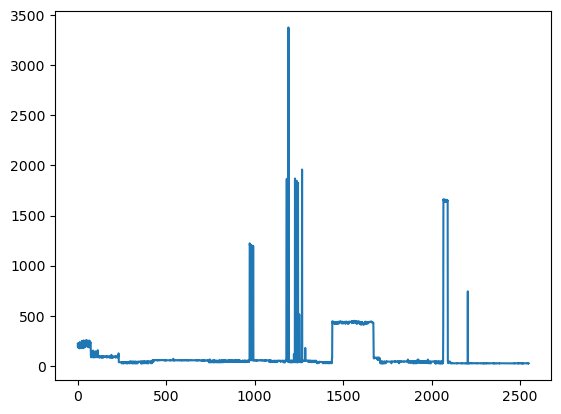

...
---------------------------------------------------------------------------
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
---------------------------------------------------------------------------
y_train
---------------------------------------------------------------------------
1st sample:  [ True False  True  True False False False  True  True False False  True
  True False False]
2nd sample:  [ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True]
3rd sample:  [False  True False  True False False False False False  True False  True
  True False False]
4th sample:  [False False  True  True False  True False  True False  True False False
 False False  True]
...
---------------------------------------------------------------------------


In [88]:
print("---------------------------------------------------------------------------")
print("x_train")
print("---------------------------------------------------------------------------")
print("2nd sample: ")
print("Time series: ")
print(x_train[1])
print("Plotted time series:")
plt.plot(x_train[1])
plt.show()
print("...")
print("---------------------------------------------------------------------------")
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("---------------------------------------------------------------------------")
print("y_train")
print("---------------------------------------------------------------------------")
print("1st sample: ", y_train[0])
print("2nd sample: ", y_train[1])
print("3rd sample: ", y_train[2])
print("4th sample: ", y_train[3])
print("...")
print("---------------------------------------------------------------------------")

## SE

<p> With this code you generate the marked mixed dataset which has 15 DiT and 11 AD: </p>
<img src="./notebook_pics/heatmap_pic.png" alt="Alt Text" width="720"/>

In [59]:
window_size=2550
nm_samples = 120_000

# EX: 15 DiT, 11 AD
DiT = 15 # Devices in Total (all devices in the household)
AD = 11  # Active Devices (devices in the household that are active)

# In the paper we generated 4 datasets for each of the blocks to get a more accurate score, 
# for the purpose of this demo we use only 1
nm_sets = 1

devicesX_Y, dataX_Y = DevicesDataXY(nm_sets, DiT, 54) #UK-DALE: 54, REFIT: 22
Dictlist = ListsToDictlist(devicesX_Y, dataX_Y, nm_sets)

for nm in range(0, nm_sets):
    x_train, x_test, y_train, y_test, labels = GenerateXXYYL(Dictlist, window_size, AD, nm, nm_samples)
    class_weights = class_weights_tool(y_test)

<strong>Example of Completed Datasets</strong>
<p>Upon completion of the code, the train and test datasets are expected to exhibit the following structure:</p>
<ol>
    <li> 
        <p><strong> x_train </strong> </p>
        <img src="./notebook_pics/x_train_SE.png" width="480"/>
    </li>
    <li> 
        <p><strong> y_train </strong> </p>
        <img src="./notebook_pics/y_train_SE.png" width="480"/>
    </li>
</ol>
<p>Within the datasets <code>x_train</code> and <code>x_test</code>, a time series of length 2550 is observed. Additionally, the datasets <code>y_train</code> and <code>y_test</code> contain arrays of 15 elements (because we have 15 DiT), each representing the device state. The elements are binary, where "True" indicates the device is ON, and "False" indicates the device is OFF.</p>

---------------------------------------------------------------------------
x_train
---------------------------------------------------------------------------
1st sample: 
Time series: 
[[ 17.]
 [ 17.]
 [ 17.]
 ...
 [423.]
 [438.]
 [408.]]
Plotted time series:


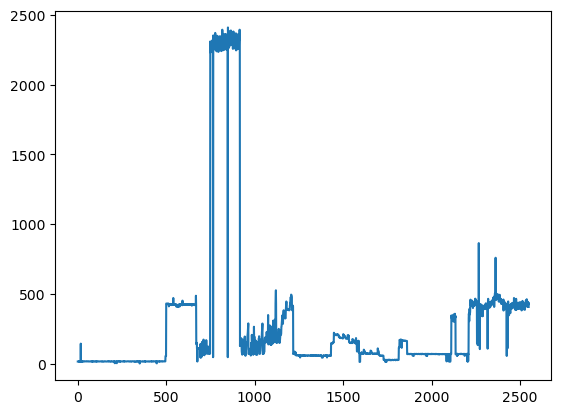

...
---------------------------------------------------------------------------
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
---------------------------------------------------------------------------
y_train
---------------------------------------------------------------------------
1st sample:  [ True  True  True  True False  True False False  True  True  True  True
  True False  True]
2nd sample:  [ True  True  True False  True  True False  True  True  True False  True
 False  True  True]
3rd sample:  [ True  True  True  True False  True False  True  True  True  True  True
 False False  True]
4th sample:  [ True False  True False  True  True  True False  True False  True  True
  True  True  True]
...
---------------------------------------------------------------------------


In [60]:
print("---------------------------------------------------------------------------")
print("x_train")
print("---------------------------------------------------------------------------")
print("1st sample: ")
print("Time series: ")
print(x_train[0])
print("Plotted time series:")
plt.plot(x_train[0])
plt.show()
print("...")
print("---------------------------------------------------------------------------")
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("---------------------------------------------------------------------------")
print("y_train")
print("---------------------------------------------------------------------------")
print("1st sample: ", y_train[0])
print("2nd sample: ", y_train[1])
print("3rd sample: ", y_train[2])
print("4th sample: ", y_train[3])
print("...")
print("---------------------------------------------------------------------------")

# Training & Evaluation

## RE

<p> This example corresponds to this cell in the heatmap: </p>
<img src="./notebook_pics/R_heatmap_pic.png" width="180"/>

In [86]:
BS = 128
LR = 0.0003
E = 20

DiT = 15
window_size = 2550

# Using the saved dataset
#saved_dataset = pickle.load(open('path','rb'))
#x_train, x_test, y_train, y_test, labels = saved_dataset[0], saved_dataset[1], saved_dataset[2], saved_dataset[3], saved_dataset[4]
class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| training ||||||||||||||||||||||||||||||||
model = CtRNN(DiT, window_size)
model.build((len(y_train)+len(y_test),window_size,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=BS, epochs=E, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
# |||||||||||||||||||||||||||||||| evaluation ||||||||||||||||||||||||||||||||
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))

Model: "CtRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2550, 1)]         0         
                                                                 
 block1_conv1 (Conv1D)       (None, 2550, 64)          256       
                                                                 
 block1_conv2 (Conv1D)       (None, 2550, 64)          12352     
                                                                 
 block1_pool (AveragePoolin  (None, 1275, 64)          0         
 g1D)                                                            
                                                                 
 block2_conv1 (Conv1D)       (None, 1275, 128)         24704     
                                                                 
 block2_conv2 (Conv1D)       (None, 1275, 128)         49280     
                                                             

## SE

<p> This example corresponds to this cell in the heatmap: </p>

<img src="./notebook_pics/heatmap_pic.png" width="480"/>

In [27]:
# Parameters according to the table 2.
BS = 128
LR = 0.0005
E = 20

# |||||||||||||||||||||||||||||||| training ||||||||||||||||||||||||||||||||
model = CtRNN(DiT, window_size)
model.build((len(y_train)+len(y_test),window_size,1))
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=BS, epochs=E, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
# |||||||||||||||||||||||||||||||| evaluation ||||||||||||||||||||||||||||||||
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))

Epoch 1/20
750/750 [==============================] - 31s 38ms/step - loss: inf - accuracy: 0.0268
Epoch 2/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.0212
Epoch 3/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.0235
Epoch 4/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.0260
Epoch 5/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.0324
Epoch 6/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.0446
Epoch 7/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.0594
Epoch 8/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.0791
Epoch 9/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.1170
Epoch 10/20
750/750 [==============================] - 27s 36ms/step - loss: inf - accuracy: 0.1482
Epoch 11/